# preparer l'environnement

### import des biblio

In [1]:
import pickle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import *
from tensorflow.keras.regularizers import L1L2

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### definir les variables global

In [2]:
DATA_PATH = "./cifar-10-batches-py/"
data_augmentation = False
modelName = "multiCouches"

### la fonction pour chager des fichiers

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### la fonction pour visualisation des data

In [4]:
def show_first_samples(x_train, y_train, labels_name):
    
    for i in range(4):
        imgs = x_train[i]
        img0 = imgs[0]
        img1 = imgs[1]
        img2 = imgs[2]
        i0 = Image.fromarray(img0)
        i1 = Image.fromarray(img1)
        i2 = Image.fromarray(img2)
        img = Image.merge("RGB",(i0,i1,i2))
        plt.imshow(img)
        print(labels_name[y_train[i]])
        plt.show()

### la fonction pour chager des data

In [5]:
def load_data():
    data_first = unpickle(DATA_PATH + "data_batch_1")
    data_x = data_first[b'data']
    data_y = data_first[b'labels']
    for i in range(2,6):
        data = unpickle(DATA_PATH + f"data_batch_{i}")
        data_x = np.vstack((data_x, data[b'data']))
        data_y += data[b'labels']
    return data_x, data_y

# Creation de model

In [6]:
def create_model(depth: int = 4):
    model = Sequential()
    model.add(Input((3072,)))

    for i in range(depth):
        model.add(Dense(3072, activation=linear))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    return model

# Preparation des data

### chargement des data et visualisation des data

b'frog'


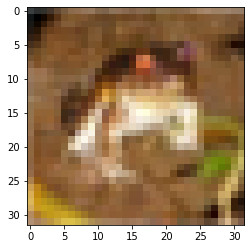

b'truck'


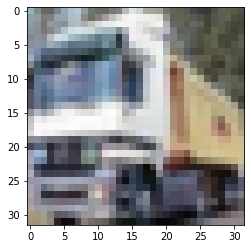

b'truck'


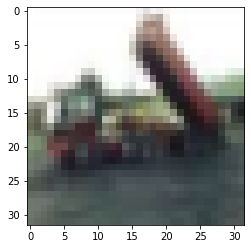

b'deer'


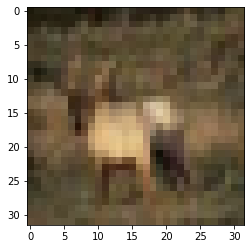

In [7]:
x_train, y_train = load_data() #load the train data cifar

data_test = unpickle(DATA_PATH + "test_batch") # load the test data
x_val, y_val = data_test[b'data'], data_test[b'labels'] 

data_info = unpickle(DATA_PATH + "batches.meta") #load the data infos
labels_name = data_info[b'label_names']

x_image = x_train.reshape(-1, 3, 32, 32)

y_train = np.array(y_train)
y_val = np.array(y_val)

show_first_samples(x_image, y_train, labels_name)

x_train = x_train / 255.0 #transfer les data au float
x_val = x_val / 255.0

# Visualisation du model

### la resume du model

In [8]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3072)              9440256   
_________________________________________________________________
activation (Activation)      (None, 3072)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
activation_1 (Activation)    (None, 3072)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3072)              9

### tracer l'image de structure

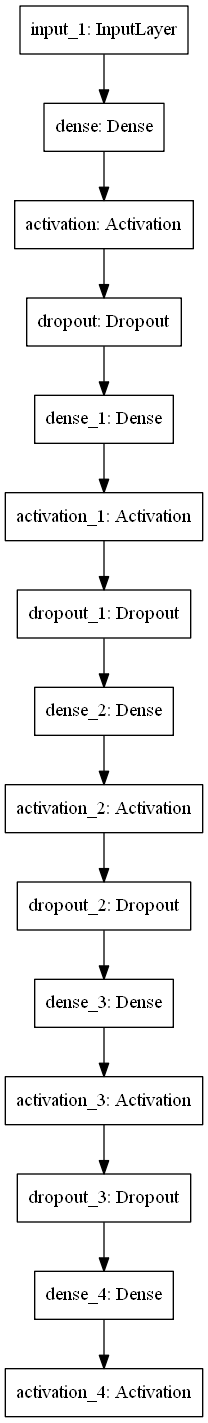

In [9]:
plot_model(model, f"{modelName}_log/{modelName}.png")

# Compile le model

### callbacks fonction : 
#### EarlyStopping : si val_accuracy n'ai pas augmenter deplus 2 epoch, la processus va arreter.
#### TensorBoard : une utils pour enregistrer les log

In [10]:
if data_augmentation:
    aug = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True)
    aug.fit(x_train)
    gen = aug.flow(x_train, y_train, batch_size=128)
    history = model.fit_generator(generator=gen, 
                            steps_per_epoch=50000/128, 
                            epochs=30, 
                            validation_data=(x_val, y_val),
                            callbacks=[
                                EarlyStopping(monitor="val_accuracy", patience=2),
                                TensorBoard(log_dir=f"{modelName}_log", histogram_freq=1)
                                ])
else:
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
            epochs=30,
            batch_size=128,
            callbacks=[
                EarlyStopping(monitor="val_accuracy", patience=2),
                TensorBoard(log_dir=f"{modelName}_log", histogram_freq=1)
            ])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 40s 806us/sample - loss: 2.0745 - accuracy: 0.2592 - val_loss: 1.8383 - val_accuracy: 0.3422
Epoch 2/30
50000/50000 [==============================] - 45s 896us/sample - loss: 1.8827 - accuracy: 0.3106 - val_loss: 1.7675 - val_accuracy: 0.3704loss: 1.8834 - ac
Epoch 3/30
50000/50000 [==============================] - 47s 937us/sample - loss: 1.8454 - accuracy: 0.3283 - val_loss: 1.7837 - val_accuracy: 0.3532
Epoch 4/30
50000/50000 [==============================] - 50s 993us/sample - loss: 1.8128 - accuracy: 0.3409 - val_loss: 1.7190 - val_accuracy: 0.3882
Epoch 5/30
50000/50000 [==============================] - 46s 918us/sample - loss: 1.7802 - accuracy: 0.3549 - val_loss: 1.7069 - val_accuracy: 0.4021
Epoch 6/30
50000/50000 [==============================] - 46s 926us/sample - loss: 1.7609 - accuracy: 0.3618 - val_loss: 1.6862 - val_accuracy: 0.4155
Epoch 7/30
50000/50000 [===

# Visualisation des resultat

### visualisation de accuracy

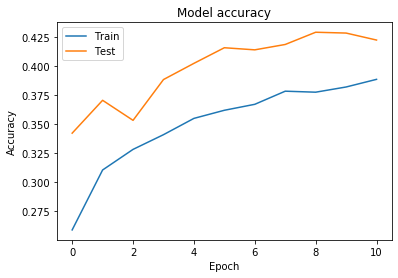

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_accuracy.png')
plt.show()

### visualisation de loss

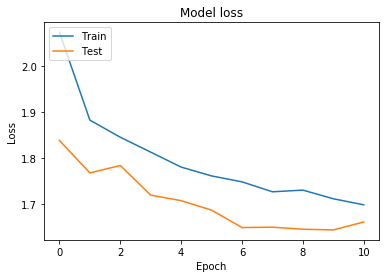

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_loss.png')
plt.show()